## 2D thermo mechanical subduction models

This notebook develops a flexible model for 2d thermo-mechanical subduction using Underworld2. All functionality is parallel-compatible. The code has been run on 48 processors, at a vertical resolution of 256 elements (Q1).

Some of the features of this model:

* use swarms and distance 'halos' to impose geometry / thermal structure -
* easy switch between thermal and compositional models
* paramter non-dimensionlisation
* checkpointing
* command line arguments can be supplied to control paramters and modelling choices



<hr>
<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br />This work is copyright Dan Sandiford and Louis Moresi. It is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.

## Package requirements

Assuming you're running underworld2 through a docker image, you will need the following python packages:

* easydict  https://pypi.python.org/pypi/easydict/

It should be no problem to do `pip install easydict` (though you'll need to do this for each container you start)

You'll also need a copy of my scripts and tools: https://github.com/dansand/unsupported.git

This is occasionally merged with the official underworld2 module of the same name, but it's safest to grab a copy of the repo: 

`git clone https://github.com/dansand/unsupported.git`, 

(easiest to clone straight into in the same directory as this notebook.)

To add the module to the pythonpath do:

```python
import os
import sys

if os.getcwd() == '/workspace/newSlab':
    sys.path.append('./unsupported')
    
```

In [2]:
#If run through Docker we'll point at the local 'unsupported dir.'
#On hpc, the path should also include a directory holding the unsupported_dan.
import os
import sys

if os.getcwd() == '/workspace/newSlab':
    #sys.path.append('./unsupported') #unsupported module located in current working dir
    sys.path.append('../unsupported') #unsupported module located in parent dir.
    

In [3]:
import numpy as np
import underworld as uw
import math
from underworld import function as fn
import glucifer
import os
import sys
from easydict import EasyDict as edict
import operator
import pickle


#
from unsupported_dan.utilities.interpolation import nn_evaluation
from unsupported_dan.interfaces.marker2D import markerLine2D
from unsupported_dan.faults.faults2D import fault2D, fault_collection
from unsupported_dan.alchemy.materialGraph import MatGraph
from unsupported_dan.checkpoint.checkpoint import checkpoint



../unsupported/unsupported_dan/utilities/__init__.py:9: UserWarning: 

The alchemy module is not supported.
Questions should be addressed to sandd@student.unimelb.edu.au 
 
  Questions should be addressed to sandd@student.unimelb.edu.au \n """
../unsupported/unsupported_dan/interfaces/__init__.py:9: UserWarning: 

The interface module is not supported.
Questions should be addressed to louis.moresi@unimelb.edu.au 
 
  Questions should be addressed to louis.moresi@unimelb.edu.au \n """
../unsupported/unsupported_dan/faults/__init__.py:9: UserWarning: 

The fault module is not supported.
Questions should be addressed to louis.moresi@unimelb.edu.au 
 
  Questions should be addressed to louis.moresi@unimelb.edu.au \n """
../unsupported/unsupported_dan/alchemy/__init__.py:9: UserWarning: 

The alchemy module is not supported.
Questions should be addressed to sandd@student.unimelb.edu.au 
 
  Questions should be addressed to sandd@student.unimelb.edu.au \n """
../unsupported/unsupported_dan/c

## Setup output directories

In [4]:
###########
#Standard output directory setup
###########


#Model letter identifier demarker
Model = "T"

#Model number identifier demarker:
ModNum = 1

#Any isolated letter / integer command line args are interpreted as Model/ModelNum

if len(sys.argv) == 1:
    ModNum = ModNum 
elif sys.argv[1] == '-f': #
    ModNum = ModNum 
else:
    for farg in sys.argv[1:]:
        if not '=' in farg: #then Assume it's a not a paramter argument
            try:
                ModNum = int(farg) #try to convert everingthing to a float, else remains string
            except ValueError:
                Model  = farg
                
                
###########
#Standard output directory setup
###########

outputPath = "results" + "/" +  str(Model) + "/" + str(ModNum) + "/" 
imagePath = outputPath + 'images/'
filePath = outputPath + 'files/'
#checkpointPath = outputPath + 'checkpoint/'
dbPath = outputPath + 'gldbs/'
xdmfPath = outputPath + 'xdmf/'
outputFile = 'results_model' + Model + '_' + str(ModNum) + '.dat'

if uw.rank()==0:
    # make directories if they don't exist
    if not os.path.isdir(outputPath):
        os.makedirs(outputPath)
    if not os.path.isdir(imagePath):
        os.makedirs(imagePath)
    if not os.path.isdir(dbPath):
        os.makedirs(dbPath)
    if not os.path.isdir(filePath):
        os.makedirs(filePath)
    if not os.path.isdir(xdmfPath):
        os.makedirs(xdmfPath)
        
uw.barrier() #Barrier here so no procs run the check in the next cell too early        

## Checkpointing

In [6]:
#*************CHECKPOINT-BLOCK**************#

#cp = checkpoint(outputPath + 'checkpoint/', loadpath='./results/A/1/checkpoint/10')
cp = checkpoint(outputPath + 'checkpoint/')

#*************CHECKPOINT-BLOCK**************#


NameError: name 'outputPath' is not defined

## Model parameters and scaling

In [7]:
dp = edict({})
#Main physical paramters
dp.depth=1000e3                         #Depth
dp.refDensity=3300.                        #reference density
dp.refGravity=9.8                          #surface gravity
dp.viscosityScale=1e20                       #reference upper mantle visc., 
dp.refDiffusivity=1e-6                     #thermal diffusivity
dp.refExpansivity=3e-5                     #surface thermal expansivity
dp.gasConstant=8.314                    #gas constant
dp.specificHeat=1250.                   #Specific heat (Jkg-1K-1)
dp.potentialTemp=1573.                  #mantle potential temp (K)
dp.surfaceTemp=273.                     #surface temp (K)
#Rheology - flow law paramters
dp.cohesionMantle=20e6                   #mantle cohesion in Byerlee law
dp.cohesionCrust=1e6                    #crust cohesion in Byerlee law
dp.frictionMantle=0.2                   #mantle friction coefficient in Byerlee law (tan(phi))
dp.frictionCrust=0.02                   #crust friction coefficient 
dp.diffusionPreExp=5.34e-10             #1./1.87e9, pre-exp factor for diffusion creep
dp.diffusionEnergy=3e5 
dp.diffusionVolume=5e-6
dp.lowerMantlePreExp=4.23e-15           #1./2.36e14
dp.lowerMantleEnergy=2.0e5
dp.lowerMantleVolume=1.5e-6
dp.lowerMantleViscFac = 30.


dp.interfacePreExp=2e7*5.34e-10            
dp.interfaceEnergy=0.5*3e5
dp.interfaceVolume=10.*5e-6
#dp.crustExponent=3.5  

dp.dislocationPreExp=5e-16              #pre-exp factor for dislocation creep
dp.dislocationEnergy=5.4e5
dp.dislocationVolume=0.9*12e-6
dp.dislocationExponent=3.5              #Dislocation creep stress exponent

    #dp.peierlsPreExp=1e-150                 #pre-exp factor for Peierls creep
    #dp.peierlsEnergy=5.4e5
    #dp.peierlsVolume=10e-6
    #dp.peierlsExponent=20.                  #Peierls creep stress exponent 
    


#Rheology - cutoff values
dp.viscosityMin=1e18
dp.viscosityMax=1e25                #viscosity max in the mantle material
dp.viscosityMinCrust=1e20               #viscosity min in the weak-crust material
dp.viscosityMaxCrust=1e20               #viscosity max in the weak-crust material
dp.yieldStressMax=300*1e6              #
dp.crustViscCutoffDepth = 100e3
dp.crustViscEndWidth = 20e3

#Intrinsic Lengths
dp.mantleCrustDepth=10.*1e3              #Crust depth
dp.faultThickness = 10.*1e3              #interface material (crust) an top of slabs
dp.crustMantleDepth=250.*1e3 
dp.lowerMantleDepth=660.*1e3  
dp.crustLimitDepth=650.*1e3             #Deeper than this, crust material rheology reverts to mantle rheology
#Slab and plate init. parameters
dp.subZoneLoc=-100e3                    #X position of subduction zone...km
dp.leftRidge=-1.*(5000e3)               #
dp.rightRidge=(5000e3)
dp.maxDepth=150e3
dp.theta=40                             #Angle of slab
dp.radiusOfCurv = 250e3                          #radius of curvature
dp.slabMaxAge=70e6                     #age of subduction plate at trench
dp.plateMaxAge=100e6                    #max age of slab (Plate model)
dp.opMaxAge=35e6                       #age of op
#Misc
dp.stickyAirDepth=100e3                 #depth of sticky air layer
dp.viscosityStickyAir=1e19              #stick air viscosity, normal
#derived params
dp.deltaTemp = dp.potentialTemp-dp.surfaceTemp
dp.tempGradMantle = (dp.refExpansivity*dp.refGravity*(dp.potentialTemp))/dp.specificHeat
dp.tempGradSlab = (dp.refExpansivity*dp.refGravity*(dp.surfaceTemp + 400.))/dp.specificHeat

#temporary, for visc. special cases
dp.velCmY = 4.



#Modelling and Physics switches

md = edict({})
md.refineMeshStatic=True
md.stickyAir=False
md.aspectRatio=5.
md.res=32
md.ppc=25                                 #particles per cell
md.elementType="Q1/dQ0"
#md.elementType="Q2/DPC1"
md.secInvFac=math.sqrt(1.)
md.courantFac=0.5                         #extra limitation on timestepping
md.thermal = True                        #thermal system or compositional
md.swarmInitialFac = 0.6                 #initial swarm layout will be int(md.ppc*md.swarmInitialFac), popControl will densify later
md.compBuoyancy = False
md.nltol = 0.01
md.maxSteps = 20000
md.checkpointEvery = 50
md.swarmUpdate = 10
md.druckerAlpha = 0.
md.druckerAlphaFault = 0.
md.penaltyMethod = True
md.opuniform = False
md.spuniform = False
md.opfixed = False
md.spfixed = False
md.buoyancyFac = 1.0
#The following are time-based actions
md.filesMy = 1.0e6 #dimensional time interval to write files
md.diffuseInitial = 5e6 # years to run initial diffusion for. Or set to zero

#some temporary flags
md.specialCaseU = 0 #md.specialCaseU=0, byerlee down to bdt
md.specialCaseL = 0 #md.specialCaseL=0, byerlee down to decoupling

md.deepCohesionFac = 1.0
md.deepFcFac = 0.0


In [10]:
uw.barrier()

##Parse any command-line args

from unsupported_dan.cl_args import easy_args
sysArgs = sys.argv

#We want to run this on both the parameter dict, and the model dict
easy_args(sysArgs, dp)
easy_args(sysArgs, md)


uw.barrier()

../unsupported/unsupported_dan/cl_args/__init__.py:9: UserWarning: 

The interface module is not supported.
Questions should be addressed to sandd@student@unimelb.edu.au 
 
  Questions should be addressed to sandd@student@unimelb.edu.au \n """


In [12]:
sf = edict({})

sf.lengthScale=2900e3
sf.viscosityScale = dp.viscosityScale
sf.stress = (dp.refDiffusivity*sf.viscosityScale)/sf.lengthScale**2
#sf.lithGrad = dp.refDensity*dp.refGravity*(sf.lengthScale)**3/(sf.viscosityScale*dp.refDiffusivity) 
sf.lithGrad = (sf.viscosityScale*dp.refDiffusivity) /(dp.refDensity*dp.refGravity*(sf.lengthScale)**3)
sf.velocity = dp.refDiffusivity/sf.lengthScale
sf.strainRate = dp.refDiffusivity/(sf.lengthScale**2)
sf.time = 1./sf.strainRate
sf.actVolume = (dp.gasConstant*dp.deltaTemp)/(dp.refDensity*dp.refGravity*sf.lengthScale)
sf.actEnergy = (dp.gasConstant*dp.deltaTemp)
sf.diffusionPreExp = 1./sf.viscosityScale
sf.deltaTemp  = dp.deltaTemp
sf.pressureDepthGrad = (dp.refDensity*dp.refGravity*sf.lengthScale**3)/(dp.viscosityScale*dp.refDiffusivity)


#dimesionless params
ndp  = edict({})

ndp.rayleigh = md.buoyancyFac*(dp.refExpansivity*dp.refDensity*dp.refGravity*dp.deltaTemp*sf.lengthScale**3)/(dp.viscosityScale*dp.refDiffusivity)

#Take care with these definitions, 
ndp.surfaceTemp = dp.surfaceTemp/sf.deltaTemp  #Ts
ndp.potentialTemp = dp.potentialTemp/sf.deltaTemp - ndp.surfaceTemp #Tp' = Tp - TS

ndp.tempGradMantle = dp.tempGradMantle/(sf.deltaTemp/sf.lengthScale)
ndp.tempGradSlab = dp.tempGradSlab/(sf.deltaTemp/sf.lengthScale)

#lengths / distances
ndp.depth = dp.depth/sf.lengthScale
ndp.leftLim = -0.5*ndp.depth*md.aspectRatio
ndp.rightLim = 0.5*ndp.depth*md.aspectRatio
ndp.faultThickness = dp.faultThickness/sf.lengthScale
ndp.leftRidge = max(ndp.leftLim,  dp.leftRidge/sf.lengthScale)
ndp.rightRidge = min(ndp.rightLim, dp.rightRidge/sf.lengthScale)
ndp.mantleCrustDepth =  dp.mantleCrustDepth/sf.lengthScale
ndp.crustLimitDepth = dp.crustLimitDepth/sf.lengthScale
ndp.lowerMantleDepth = dp.lowerMantleDepth/sf.lengthScale


#times - for convenience and sanity the dimensional values are in years, conversion to seconds happens here
ndp.slabMaxAge =  dp.slabMaxAge*(3600*24*365)/sf.time
ndp.plateMaxAge =  dp.plateMaxAge*(3600*24*365)/sf.time
ndp.opMaxAge = dp.opMaxAge*(3600*24*365)/sf.time


#Rheology - flow law paramters
ndp.cohesionMantle=dp.cohesionMantle/sf.stress                  #mantle cohesion in Byerlee law
ndp.cohesionCrust=dp.cohesionCrust/sf.stress                  #crust cohesion in Byerlee law
ndp.frictionMantle=dp.frictionMantle/sf.lithGrad                  #mantle friction coefficient in Byerlee law (tan(phi))
ndp.frictionCrust=dp.frictionCrust/sf.lithGrad                  #crust friction coefficient 
ndp.diffusionPreExp=dp.diffusionPreExp/sf.diffusionPreExp                #pre-exp factor for diffusion creep
ndp.diffusionEnergy=dp.diffusionEnergy/sf.actEnergy
ndp.diffusionVolume=dp.diffusionVolume/sf.actVolume


#
ndp.interfacePreExp = dp.interfacePreExp/sf.diffusionPreExp           
ndp.interfaceEnergy = dp.interfaceEnergy/sf.actEnergy
ndp.interfaceVolume = dp.interfaceVolume/sf.actVolume



ndp.lowerMantlePreExp=dp.lowerMantlePreExp/sf.diffusionPreExp 
ndp.lowerMantleEnergy=dp.lowerMantleEnergy/sf.actEnergy
ndp.lowerMantleVolume=dp.lowerMantleVolume/sf.actVolume
ndp.yieldStressMax=dp.yieldStressMax/sf.stress 
#Rheology - cutoff values
ndp.viscosityMin= dp.viscosityMin /sf.viscosityScale
ndp.viscosityMax=dp.viscosityMax/sf.viscosityScale
ndp.viscosityMinCrust= dp.viscosityMinCrust /sf.viscosityScale
ndp.viscosityMaxCrust = dp.viscosityMaxCrust/sf.viscosityScale
ndp.lowerMantleViscFac = dp.lowerMantleViscFac
ndp.crustViscCutoffDepth = dp.crustViscCutoffDepth/sf.lengthScale
ndp.crustViscEndWidth = dp.crustViscEndWidth/sf.lengthScale




#Slab and plate init. parameters
ndp.subZoneLoc = dp.subZoneLoc/sf.lengthScale
ndp.maxDepth = dp.maxDepth/sf.lengthScale
ndp.radiusOfCurv = dp.radiusOfCurv/sf.lengthScale



In [13]:
#*************CHECKPOINT-BLOCK**************#


#if restart, attempt to read in saved dicts. 
if cp.restart:
    try:
        with open(os.path.join(cp.loadpath, 'dp.pkl'), 'rb') as fp:
                            dp = pickle.load(fp)
        with open(os.path.join(cp.loadpath, 'sf.pkl'), 'rb') as fp:
                            sf = pickle.load(fp)
        with open(os.path.join(cp.loadpath, 'md.pkl'), 'rb') as fp:
                            md = pickle.load(fp)

    except:
        print("couldn't load paramter dictionaries on restart")


    
#add dicts to the checkpointinng object
cp.addDict(dp, 'dp')
cp.addDict(sf, 'sf')
cp.addDict(md, 'md')
#*************CHECKPOINT-BLOCK**************#


## Build Mesh and FE variables

In [14]:
#Domain and Mesh paramters
yres = int(md.res)
xres = int(md.res*12) 



mesh = uw.mesh.FeMesh_Cartesian( elementType = (md.elementType),
                                 elementRes  = (xres, yres), 
                                 minCoord    = (ndp.leftLim, 1. - ndp.depth), 
                                 maxCoord    = (ndp.rightLim, 1.)) 

velocityField   = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=2 )
pressureField   = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )
temperatureField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )

if md.thermal:
    temperatureDotField = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 ) #create this only if Adv-diff
    diffusivityFn = fn.misc.constant(1.)
    
    
    
# Any extra mesh vars. we want to define (mostly to facilite saving as xdmf)
strainRateField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )
viscosityField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )
    


In [15]:
#*************CHECKPOINT-BLOCK**************#
cp.addObject(velocityField,'velocityField')
cp.addObject(pressureField,'pressureField')
if md.thermal:
    cp.addObject(temperatureField,'temperatureField')
    cp.addObject(temperatureDotField,'temperatureDotField')
    

#*************CHECKPOINT-BLOCK**************#

In [16]:
#print(cp.objDict.keys())

In [17]:
#*************CHECKPOINT-BLOCK**************#

if cp.restart:
    velocityField.load(cp.loadpath + '/velocityField.h5')
    pressureField.load(cp.loadpath + '/pressureField.h5')
    if md.thermal:
        temperatureField.load(cp.loadpath + '/temperatureField.h5')
        temperatureDotField.load(cp.loadpath + '/temperatureDotField.h5')
#*************CHECKPOINT-BLOCK**************#


In [18]:
#miscellaneous Uw functions functions

coordinate = fn.input()
depthFn = mesh.maxCoord[1] - coordinate[1] #a function providing the depth


xFn = coordinate[0]  #a function providing the x-coordinate
yFn = coordinate[1]





#Create a binary circle
def inCircleFnGenerator(centre, radius):
    coord = fn.input()
    offsetFn = coord - centre
    return fn.math.dot( offsetFn, offsetFn ) < radius**2


## Static Mesh refinement

In [120]:
if md.refineMeshStatic:
    mesh.reset()

    jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
    yFn = coordinate[1]
    yField = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=1 )
    yField.data[:] = 0.
    yBC = uw.conditions.DirichletCondition( variable=yField, indexSetsPerDof=(jWalls,) )

    # set bottom wall temperature bc
    for index in mesh.specialSets["MinJ_VertexSet"]:
        yField.data[index] = mesh.minCoord[1]
    # set top wall temperature bc
    for index in mesh.specialSets["MaxJ_VertexSet"]:
        yField.data[index] = mesh.maxCoord[1]



    s = 4
    intensityFac = 6.
    intensityFn = (((yFn - mesh.minCoord[1])/(mesh.maxCoord[1]-mesh.minCoord[1]))**s)
    intensityFn *= intensityFac
    intensityFn += 1.


    yLaplaceEquation = uw.systems.SteadyStateHeat(temperatureField=yField, fn_diffusivity=intensityFn, conditions=[yBC,])

    # get the demarker heat equation solver
    yLaplaceSolver = uw.systems.Solver(yLaplaceEquation)
    # solve
    yLaplaceSolver.solve()


    #Get the array of Y positions - copy may be necessary, not sure. 
    newYpos = yField.data.copy() 

    uw.barrier()
    with mesh.deform_mesh():
         mesh.data[:,1] = newYpos[:,0]

## Boundary Conditions

In [95]:
#Stokes BCs

iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
tWalls = mesh.specialSets["MaxJ_VertexSet"]
bWalls =mesh.specialSets["MinJ_VertexSet"]
      
        
freeslipBC = uw.conditions.DirichletCondition( variable      = velocityField, 
                                               indexSetsPerDof = ( iWalls, jWalls) )

In [96]:
#Energy BCs

if md.thermal:
    dirichTempBC = uw.conditions.DirichletCondition(     variable=temperatureField, 
                                              indexSetsPerDof=(tWalls,) )

## Swarm

In [97]:
#Materials
mantleID = 0
crustID = 1
airID = 2      #in case we use sticky air

#list of all material indexes
material_list = [mantleID, crustID, airID]

In [98]:
#*************CHECKPOINT-BLOCK**************#

swarm = uw.swarm.Swarm(mesh=mesh, particleEscape=True)
cp.addObject(swarm,'swarm')
materialVariable      = swarm.add_variable( dataType="int", count=1 )
cp.addObject(materialVariable,'materialVariable')
proxyTempVariable = swarm.add_variable( dataType="double", count=1 )
if not md.thermal:
    cp.addObject(proxyTempVariable,'proxyTempVariable')


if cp.restart:
    swarm.load(cp.loadpath + '/swarm.h5')
    materialVariable.load(cp.loadpath + '/materialVariable.h5')
    if not md.thermal:
        proxyTempVariable.load(cp.loadpath + '/proxyTempVariable.h5')   


else:
    layout = uw.swarm.layouts.PerCellRandomLayout(swarm=swarm, particlesPerCell=int(md.ppc*md.swarmInitialFac))
    swarm.populate_using_layout( layout=layout ) # Now use it to populate.
    proxyTempVariable.data[:] = 0.0
    materialVariable.data[:] = mantleID

#*************CHECKPOINT-BLOCK**************#


In [99]:
#These variables don;t need checkpointing. They can / should be rebuilt

signedDistanceVariable = swarm.add_variable( dataType="double", count=1 )
#directorVector   = swarm.add_variable( dataType="double", count=2)

#directorVector.data[:,:] = 0.0
signedDistanceVariable.data[:] = 0.0


In [100]:

#Pass this to Figures to see full extent
bBox=((mesh.minCoord[0], mesh.minCoord[1]),(mesh.maxCoord[0], mesh.maxCoord[1]))

## Initial Conditions

In [101]:
#plate depth

#Flags to control plate behaviour: md.opuniform, md.spuniform, md.opfixed, md.spfixed

#T&S 4.126
thicknessAtTrench = 2.32*math.sqrt(1.*ndp.slabMaxAge)

sig = 150e3/sf.lengthScale
ridgeFn = 1. -  \
                fn.math.exp(-1.*(xFn - ndp.leftRidge)**2/(2 * sig**2))- \
                fn.math.exp(-1.*(xFn - ndp.rightRidge)**2/(2 * sig**2))

spAge = ndp.slabMaxAge*fn.math.abs((ndp.leftRidge - xFn)/(ndp.subZoneLoc - ndp.leftRidge))
opAge = ndp.opMaxAge*fn.math.abs((ndp.rightRidge - xFn)/(ndp.subZoneLoc - ndp.rightRidge))

if md.spuniform:
    if not md.spfixed:
        spAge = ridgeFn*ndp.slabMaxAge
    else:
        spAge = fn.misc.constant(ndp.slabMaxAge)
        
if md.opuniform:
    if not md.opfixed:
        opAge = ridgeFn*ndp.opMaxAge
    else:
        opAge = fn.misc.constant(ndp.opMaxAge)

proxyageFn = fn.branching.conditional([(xFn <= ndp.subZoneLoc, spAge), #idea is to make this arbitrarily complex
                                  (True, opAge)])



## Marker lines  for slab, fault, tracking

In [103]:
def slab_top(trench, normal, gradientFn, ds, maxDepth, mesh):
    """
    Create points representing the top of a slab from trench to maxDepth
    
    Parameter
    ---------
    trench : list or list like 
            Points represnting trench location, 
    normal: list or list like
            vector in the horizontal plane normal to trench
    gradientFn: function
             function that returns the dip or the slab dz/ds 
             where s is the distance along the normal vector
    ds: float
            distance between points, in model coordinates
    
    max depth: float, or list or list like
            Maximum depth of slab
    mesh: uw 2 mesh   
    
    """
    
    #convert everything to numpy arrays
    trench = np.array(trench)
    normal = np.array(normal)/np.linalg.norm(normal)
    maxDepth = np.array(maxDepth)
    
    #test if gradientFn is a function   
    points = []
    points.append(list(trench))
    
    #set starting values
    #normal/= np.linalg.norm(normal)#unitize
    vertical = np.zeros(mesh.dim)
    vertical[-1] = -1.

    P0 = trench.copy()
    F = gradientFn(0.)
    #print(F)
    H = 0.
    V = 0.
    #print(normal, F)
    S = normal.copy()

    S[-1] = F     #assumes the last component is vertical
    S/= np.linalg.norm(S) #unitize

    
    while V < maxDepth:
        
        #Get next set of points
        P1 = P0 + S*ds
        points.append(list(P1))
        P0 = P1
        
        #update, H, V, F, S
        H +=  np.dot(S*ds, normal)
        V +=  abs(((S*ds)[-1]))
        F = gradientFn(H)        
        S = normal.copy()
        S[-1] = F     #assumes the last component is vertical
        S/= np.linalg.norm(S) #unitize

        
        
        
    return(np.array(points))
    

In [104]:
#Create some slab gradient functions to use with slab_top()


def linearGradientFn(S):
    return np.tan(np.deg2rad(-45.))


def circGradientFn(S):
    if S == 0.:
        return 0.
    elif S < ndp.radiusOfCurv:
        return -S/np.sqrt((ndp.radiusOfCurv**2 - S**2))
    else:
        return -1e5
    
    
def polyGradientFn(S):
    if S == 0.:
        return 0.
    else:
        return -1*(S/ndp.radiusOfCurv)**2


### slab top

In [105]:
ds = 5e3/sf.lengthScale
normal = [1.,0.]



#data1 = slab_top([ndp.subZoneLoc, 1.0], normal, linearGradientFn, ds, ndp.maxDepth, mesh)
data2 = slab_top([ndp.subZoneLoc, 1.0], normal, polyGradientFn, ds, ndp.maxDepth, mesh)
#data3 = slab_top([ndp.subZoneLoc, 1.0], normal, circGradientFn, ds, ndp.maxDepth, mesh)

In [106]:
slabxs = data2[:,0]
slabys = data2[:,1]

In [107]:
slabLine = markerLine2D(mesh, velocityField, slabxs, slabys, thicknessAtTrench, 1.)


In [108]:
#Assign the signed distance for the slab - in this case we only want the portion where the signed distance is positive


#Note distance=2.*thicknessAtTrench: we actually want to allow distance greater than thicknessAtTrench in the kDTree query, 
#as some of these distances will not be orthogonal to the marker line, the dot product in the function will project these distances onto the normal vector
#We'll cull distances greater than thicknessAtTrench with a numpy boolean slice - this is a big advantage in parallel


sd, pts = slabLine.compute_signed_distance(swarm.particleCoordinates.data, distance=2.*thicknessAtTrench)
signedDistanceVariable.data[np.logical_and(sd>0, sd<=slabLine.thickness)] = sd[np.logical_and(sd>0, sd<=slabLine.thickness)]



#signedDistanceVariable.data[signedDistanceVariable.data > thicknessAtTrench] = 0.



#signedDistanceVariable.data[:] = sd


1


In [109]:
slabXConds = operator.and_(xFn > slabxs.min(), xFn < slabxs.max())
slabYConds = depthFn < 1. - slabys.min()

#Two functions we'll use to limit the region of the initial thermal stancil
slabRegion =  fn.branching.conditional([(operator.and_(slabXConds,slabYConds), True),
                          (True, False)])

#slabCirc = inCircleFnGenerator((ndp.subZoneLoc, 1.0 - ndp.maxDepth), ndp.maxDepth)

In [110]:
bufferlength = 1e3/sf.lengthScale

plateDepthFn = fn.branching.conditional([(depthFn < thicknessAtTrench, depthFn),
                                        (True, 1.)])

#plateTempProxFn = fn.math.erf((depthFn*sf.lengthScale)/(2.3*fn.math.sqrt(dp.refDiffusivity*proxyageFn)))
plateTempProxFn = ndp.potentialTemp*fn.math.erf((plateDepthFn)/(2.*fn.math.sqrt(1.*proxyageFn)))

#slabTempProx  = fn.math.erf((signedDistanceVariable*sf.lengthScale)/(2.*fn.math.sqrt(dp.refDiffusivity*proxyageFn)))
slabTempProx  = ndp.potentialTemp*fn.math.erf((signedDistanceVariable)/(2.*np.sqrt(1.*ndp.slabMaxAge)))


proxytempConds = fn.branching.conditional([(signedDistanceVariable < bufferlength, plateTempProxFn),
                          #(operator.and_(slabRegion, slabCirc), fn.misc.min(slabTempProx , plateTempProxFn)),
                          (slabRegion,  fn.misc.min(slabTempProx , plateTempProxFn)),                 

                          (True, plateTempProxFn)]) 


#*************CHECKPOINT-BLOCK**************#

if not cp.restart:
    proxyTempVariable.data[:] = proxytempConds.evaluate(swarm)

#*************CHECKPOINT-BLOCK**************#


### marker

In this notebook, the markerLine helps us set up the weak interface material, as well as tracking various flow metrics

It could also be used it to define a proximity of Transversely Isotropic frictional behaviour

In [111]:
morexs = np.arange(mesh.minCoord[0] + 100e3/sf.lengthScale, ndp.subZoneLoc, ds)[:-1]
moreys = mesh.maxCoord[1]*np.ones(morexs.shape)


In [112]:
#Build marker: copy the slab line, then move using the normal vector (director)

markerxs = np.concatenate((morexs,slabxs[:-2]))
markerys = np.concatenate((moreys,slabys[:-2]))
marker = markerLine2D(mesh, velocityField,markerxs, markerys, ndp.faultThickness,  1)

with marker.swarm.deform_swarm():
    marker.swarm.particleCoordinates.data[:] += marker.director.data*ndp.faultThickness
    

marker.rebuild()
marker.swarm.update_particle_owners()

In [113]:
print('got to test point')

uw.barrier()

got to test point


In [114]:
#inform the mesh of the marker

sd, pts0 = marker.compute_signed_distance(swarm.particleCoordinates.data, distance=thicknessAtTrench)
sp, pts0 = marker.compute_marker_proximity(swarm.particleCoordinates.data, distance=ndp.faultThickness)

#*************CHECKPOINT-BLOCK**************#
if not cp.restart:
    materialVariable.data[np.logical_and(sd<0,sp == marker.ID)] = sp[np.logical_and(sd<0,sp == marker.ID)]
#*************CHECKPOINT-BLOCK**************#

    
    
#dv, nzv = marker.compute_normals(swarm.particleCoordinates.data)
#directorVector.data[nzv] = dv[nzv]

1


### surface

In [115]:
surfacexs = np.linspace(mesh.minCoord[0], mesh.maxCoord[0], md.res*md.aspectRatio*2)
surfaceys = np.ones(surfacexs.shape[0])
surfaceLine = markerLine2D(mesh, velocityField,surfacexs, surfaceys , ndp.faultThickness,  2)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':


In [116]:
#variables for surface

surfVelx = uw.swarm.SwarmVariable(surfaceLine.swarm, 'double', 1)
surfStrain = uw.swarm.SwarmVariable(surfaceLine.swarm, 'double', 1)
surfVisc = uw.swarm.SwarmVariable(surfaceLine.swarm, 'double', 1)
surfTgrad = uw.swarm.SwarmVariable(surfaceLine.swarm, 'double', 1)


#variables for mid-lithsphere (saved on surface swarm)
midlithEvalEvalPoints = uw.swarm.SwarmVariable(surfaceLine.swarm, 'double', 2)
midlithVisc = uw.swarm.SwarmVariable(surfaceLine.swarm, 'double', 1)
midlithSr2Inv = uw.swarm.SwarmVariable(surfaceLine.swarm, 'double', 1)
midlithStrainTens = uw.swarm.SwarmVariable(surfaceLine.swarm, 'double', 3)

## Interpolate to temperature field

In [117]:
def swarmToTemp():

    _ix, _weights, _dist = nn_evaluation(swarm.particleCoordinates.data, mesh.data, n=4, weighted=True)


    #_dist.shape, mesh.data.shape
    #if 
    tempMapTol = 0.2
    tempMapMask = _dist.min(axis=1) < tempMapTol*(1. - mesh.minCoord[1])/mesh.elementRes[1] 
    
    #temperatureField.data[:] = 0.
    temperatureField.data[:] = ndp.potentialTemp #first set to dimensionless potential temp

    #now used IDW to assign temp from particles to Field
    #this is looking pretty ugly; nn_evaluation could use some grooming
    temperatureField.data[:,0][tempMapMask] = np.average(proxyTempVariable.evaluate(swarm)[_ix][tempMapMask][:,:,0],weights=_weights[tempMapMask], axis=1)

    #now cleanup any values that have fallen outside the Bcs

    temperatureField.data[temperatureField.data > 1.] = ndp.potentialTemp
    temperatureField.data[temperatureField.data < 0.] = 0.
    
    #and cleanup the BCs
    
    temperatureField.data[bWalls.data] = ndp.potentialTemp
    temperatureField.data[tWalls.data] = 0.


In [118]:
#map proxy temp (swarm var) to mesh variable

if not cp.restart:
    swarmToTemp()

In [119]:
#fig= glucifer.Figure(quality=3, boundingBox= bBox)

#fig.append( glucifer.objects.Surface(mesh, temperatureField ))
#fig.append( glucifer.objects.Points(swarm, temperatureField, pointSize=2))
#
#fig.show()
#fig.save_database('test.gldb')

## adiabatic temp correction

In [120]:
#Adiabatic correction: this is added to the arrhenius laws to simulate the adiabatic component
#We'll use a double linearisation of the adiabatic temp function:

#ndp.tempGradMantle linearised at the mantle potential temp
#dp.tempGradSlab linearised at typical slab temp


tempAtTrench  = ndp.potentialTemp*math.erf((thicknessAtTrench)/(2.*math.sqrt(1.*ndp.slabMaxAge))) 
#this is the isotherm used to define the slab / mantle boundary, should be 0.9*Tp,


dp.tempGradMantle, dp.tempGradSlab

if md.thermal:
    adiabaticCorrectFn = fn.branching.conditional([(temperatureField > tempAtTrench, depthFn*ndp.tempGradMantle), #idea is to make this arbitrarily complex
                                      (True, depthFn*ndp.tempGradSlab) ])
else:
    adiabaticCorrectFn = fn.branching.conditional([(proxyTempVariable > tempAtTrench, depthFn*ndp.tempGradMantle), #idea is to make this arbitrarily complex
                                      (True, depthFn*ndp.tempGradSlab) ])


#This will need alteration if we are using non Global particles. The adiabaticCorrectFn will need to be wrapped in a 
#swarm.fn_particle_found() conditional

In [121]:
#ndp.tempGradMantle
#ndp.tempGradMantle

In [122]:
#fig= glucifer.Figure(quality=3, boundingBox= bBox)

#fig.append( glucifer.objects.Mesh(mesh ))
#fig.append( glucifer.objects.Points(swarm, proxyTempVariable + adiabaticCorrectFn, pointSize=1))

#fig.show()

## Swarm densification

Try to build our initial geometry with less particles that are required dynamically, then use population_control to fill out the swarm

In [123]:
population_control = uw.swarm.PopulationControl(swarm, deleteThreshold=0.006, splitThreshold=0.25, maxDeletions=1, maxSplits=3, aggressive=True,aggressiveThreshold=0.9, particlesPerCell=int(md.ppc))


#

In [124]:
def repopulate():
    thresh = 5000.
    diff = thresh + 1
    count = 1
    maxLoops = 10
    pg = np.copy(swarm.particleGlobalCount)
    while abs(diff) > thresh and count < maxLoops + 1:
        population_control.repopulate()
        diff = swarm.particleGlobalCount - pg
        pg = swarm.particleGlobalCount
        #print(str(count), str(pg), str(diff))
        count += 1
    

In [125]:
#run repop function
repopulate()

In [126]:
#((float(swarm.particleGlobalCount)/mesh.elementsGlobal))/md.ppc

## MOR restriction Fn

Use the temperature gradient to define a restriction around the Ridges
This coud be used to determin locations for crust creation, etc.

In [127]:
depthMorTest = 50e3/sf.lengthScale

nearSurfTempGrad = fn.branching.conditional( ((depthFn < depthMorTest, temperatureField.fn_gradient[1] ), 
                                           (True,                      0.)  ))

morRestrictFn = fn.math.abs(nearSurfTempGrad) < 50.


In [128]:
#%pylab inline
#plt.scatter(mesh.data[tWalls.data][:,0],nearSurfTempGrad.evaluate(tWalls))
#

In [129]:
#fig= glucifer.Figure(quality=3, boundingBox= bBox)
#fig.append( glucifer.objects.Surface(mesh,repopMaskFn))
#fig.append( glucifer.objects.Points(swarm, morRestrictFn, pointSize=2))

#fig.show()


##  Material Graph

In [130]:
###################
#initial particle layout
###################

#Setup the graph object
MG = MatGraph()

#First thing to do is to add all the material types to the graph (i.e add nodes)
MG.add_nodes_from(material_list)

#mantle  => crust
MG.add_transition((mantleID,crustID), depthFn, operator.lt, ndp.mantleCrustDepth)
MG.add_transition((mantleID,crustID), morRestrictFn, operator.gt, 0.5)
MG.add_transition((mantleID,crustID), xFn, operator.lt, ndp.subZoneLoc)

                  
#crust  => mantle                
MG.add_transition((crustID, mantleID), depthFn, operator.gt, ndp.crustLimitDepth)

MG.build_condition_list(materialVariable)

if not cp.restart:
    materialVariable.data[:] = fn.branching.conditional(MG.condition_list).evaluate(swarm)

In [131]:
#Final particle transformation rules
#restrict crust creation - avoid crust on the upper plate

MG.remove_edges_from([(mantleID,crustID)])

#mantle  => crust
MG.add_transition((mantleID,crustID), depthFn, operator.lt, ndp.mantleCrustDepth)
MG.add_transition((mantleID,crustID), morRestrictFn, operator.gt, 0.5)
MG.add_transition((mantleID,crustID), xFn, operator.lt, (mesh.minCoord[0] - ndp.subZoneLoc)/2.)

MG.build_condition_list(materialVariable)

In [132]:
#fig3= glucifer.Figure(quality=3, boundingBox=bBox)
#fig3.append( glucifer.objects.Points(swarm,materialVariable, pointSize=2))
#fig3.show()
#fig3.save_database('test.gldb')

In [133]:
#ndp.crustLimitDepth *sf.lengthScale

## choose temp field to use

In [134]:
if md.thermal:
    temperatureFn = temperatureField
else:
    temperatureFn = proxyTempVariable

## Rheology

In [135]:
#Set up any functions required by the rheology
#strainRate_2ndInvariant.evaluate((0.000921625, 0.982207))

In [136]:

symStrainrate = fn.tensor.symmetric( 
                            velocityField.fn_gradient )

#Set up any functions required by the rheology
strainRate_2ndInvariant = fn.tensor.second_invariant( 
                            fn.tensor.symmetric( 
                            velocityField.fn_gradient ))



def safe_visc(func, viscmin=ndp.viscosityMin, viscmax=ndp.viscosityMax):
    return fn.misc.max(viscmin, fn.misc.min(viscmax, func))



#Add some portion of dynamic pressure to the depth-dependent Yield function
#dynamicPressureProxyDepthFn = pressureField/ndp.rayleigh
dynamicPressureProxyDepthFn = pressureField/sf.pressureDepthGrad

druckerDepthFn = fn.misc.max(0.0, depthFn + md.druckerAlpha*(dynamicPressureProxyDepthFn))
druckerFaultDepthFn = fn.misc.max(0.0, depthFn + md.druckerAlphaFault*(dynamicPressureProxyDepthFn))

In [137]:
#(#1./ndp.interfacePreExp)*\
  #    fn.math.exp( ((ndp.interfaceEnergy + (depthFn*ndp.interfaceVolume))/((temperatureFn+ adiabaticCorrectFn + ndp.surfaceTemp))))
#ndp.interfacePreExp, ndp.interfaceEnergy, ndp.interfaceVolume, ndp.surfaceTemp

In [138]:
##Diffusion Creep
diffusionUM = (1./ndp.diffusionPreExp)*\
            fn.math.exp( ((ndp.diffusionEnergy + (depthFn*ndp.diffusionVolume))/((temperatureFn+ adiabaticCorrectFn + ndp.surfaceTemp))))

diffusionLM = ndp.lowerMantleViscFac*(1./ndp.lowerMantlePreExp)*\
            fn.math.exp( ((ndp.lowerMantleEnergy + (depthFn*ndp.lowerMantleVolume))/((temperatureFn+ adiabaticCorrectFn + ndp.surfaceTemp))))


diffusionInterface = (1./ndp.interfacePreExp)*\
            fn.math.exp( ((ndp.interfaceEnergy + (depthFn*ndp.interfaceVolume))/((temperatureFn+ adiabaticCorrectFn + ndp.surfaceTemp))))

    
    
diffusion = fn.branching.conditional( ((depthFn < ndp.lowerMantleDepth, diffusionUM ), 
                                           (True,                      diffusionLM )  ))

#interfaceDiffusion = fn.branching.conditional( ((depthFn < ndp.lowerMantleDepth, diffusionInterface ), 
#                                           (True,                      diffusionLM )  ))
 
#interfaceDiffusion = safe_visc(interfaceDiffusion, viscmax=1e5)

    
diffusion = safe_visc(diffusion, viscmax=1e5)


    
#Define the mantle Plasticity
ys =  ndp.cohesionMantle + (druckerDepthFn*ndp.frictionMantle)
ysf = fn.misc.min(ys, ndp.yieldStressMax)
yielding = ysf/(2.*(strainRate_2ndInvariant) + 1e-15) 





In [139]:
##Crust plasticity
crustys =  ndp.cohesionCrust + (druckerFaultDepthFn*ndp.frictionCrust)
crustysf = fn.misc.min(crustys, ndp.yieldStressMax)
#crustYielding0 = crustysf/(2.*(strainRate_2ndInvariant) + 1e-15) 


In [142]:
#md.specialCaseL = 4

In [220]:
###This whole bit is going to handle some special cases
###providing viscous approximations to different megathrust stress profiles

#Rheology ad-hoc crust viscosuty
dp.bdt = 50e3
dp.decouple = 100e3
#dp.velCmY = 4.
dp.strainRate = ((dp.velCmY*1e-2)/(3600*24*365))/ (dp.faultThickness)
dp.stressBdt = dp.cohesionCrust + dp.frictionCrust*(dp.refDensity*dp.refGravity*dp.bdt)
dp.effViscBdt =  (dp.stressBdt/ (2*dp.strainRate ))
dp.stressD = 1e6
dp.effViscD = (dp.stressD)/ (2*dp.strainRate )
dp.stressConst = 10e6
dp.effViscC = (dp.stressConst)/ (2*dp.strainRate )
                  


#Set up a bunch of stresses and effective viscosities for a given subduction velocity / interface width
ndp.strainRate = dp.strainRate/sf.strainRate
 
ndp.bdt = dp.bdt/sf.lengthScale
ndp.decouple = dp.decouple/sf.lengthScale
ndp.stressBdt= dp.stressBdt/sf.stress
ndp.effViscBdt = dp.effViscBdt/sf.viscosityScale
ndp.stressD = dp.stressD/sf.stress
ndp.effViscD = dp.effViscD/sf.viscosityScale
ndp.effViscC = dp.effViscC/sf.viscosityScale


#Flags allow us to control the stress profiles independently in the upper (< Bdt) and lower interface

#deafaul is psuedo-plastic byerlee law (uppper lower visc. limits will also apply)
crustyieldingB = crustysf/(2.*(strainRate_2ndInvariant) + 1e-15) 

#these alter the visc. in the upper part of the interface
if md.specialCaseU ==1:
    crustyieldingB  = crustysf/(2.*(ndp.strainRate)) #approx-Byerlee upper
if md.specialCaseU ==2:
    crustyieldingB  = ndp.effViscBdt #constant approx BDT stress in upper 
if md.specialCaseU ==3:
    crustyieldingB  = ndp.effViscC #arbitrary constant stress in upper


#Default for whole inteface is whatever we chose for upper... unless
crustyielding0 = crustyieldingB

#explicitly change the viscosity in the lower part of the interface
#special cases
if md.specialCaseL==1:
    crustyielding0 = crustyieldingB #approx-Byerlee lower
#special cases
if md.specialCaseL==2: #constant approx BDT stress in lower
    crustyielding0 = fn.branching.conditional( ((depthFn < ndp.bdt, crustyieldingB ), 
                                           (True,                      ndp.effViscBdt)  ))
#special cases
if md.specialCaseL==3: #decreasing stress in the lower
    slopeEta = (ndp.effViscBdt - ndp.effViscD)/(ndp.bdt - ndp.decouple)
    reducingViscFn = slopeEta*depthFn - (slopeEta*ndp.bdt) + ndp.effViscBdt
    crustyielding0 = fn.branching.conditional( ((depthFn < ndp.bdt, crustyieldingB ),
                                                (operator.and_(depthFn > ndp.bdt, depthFn < ndp.decouple),  reducingViscFn),
                                           (True,                      ndp.effViscD)  ))
    
#special cases
if md.specialCaseL==4: #decreasing stress in the lower
    effStressLower = md.deepCohesionFac*(ndp.stressBdt) + md.deepFcFac*((depthFn - ndp.bdt) *ndp.frictionCrust)
    effViscLower = fn.misc.max(ndp.viscosityMinCrust, effStressLower /(2.*ndp.strainRate + 1e-15))

    crustyielding0 = fn.branching.conditional( ((depthFn < ndp.bdt, crustyieldingB ), 
                                           (True,                      effViscLower)  ))


In [222]:
def cosine_taper(increasingFn, startval, width):
    cosinusoid= 0.5*(1. - fn.math.cos((np.pi*(increasingFn - startval))/(width)) )
    taperFn = fn.branching.conditional( ((increasingFn < startval, 0. ),
                                            (increasingFn > (startval + width), 1. ), 
                                           (True,                      cosinusoid)  ))
    return taperFn
    

In [69]:
#This bit phases out the weak crust (effective plastic viscosity and visc. max) over specified depths
depthTaperFn = cosine_taper(depthFn, ndp.crustViscCutoffDepth, ndp.crustViscEndWidth)

crustyielding = crustyielding0*(1. - depthTaperFn) + depthTaperFn*yielding
viscmaxCrustFn = ndp.viscosityMaxCrust*(1. - depthTaperFn) + depthTaperFn*ndp.viscosityMax



#combined rheologies

mantleViscosityFn = safe_visc(fn.misc.min(diffusion, yielding), viscmin=ndp.viscosityMin, viscmax=ndp.viscosityMax)
#interfaceViscosityFn = safe_visc(fn.misc.min(diffusion, crustyielding), viscmin=ndp.viscosityMinCrust, viscmax=viscmaxCrustFn)

#for the moment both the byerlee effective viscosity, and the ad-hoc deep interface visc. are contained in crustyielding
interfaceViscosityFn = safe_visc(crustyielding, viscmin=ndp.viscosityMinCrust, viscmax=viscmaxCrustFn)

In [70]:
viscosityMapFn = fn.branching.map( fn_key = materialVariable,
                         mapping = {0:mantleViscosityFn,
                                    1:interfaceViscosityFn} )




In [71]:
#ctanhFn0 = 0.5*(1. + fn.math.sin((np.pi*(depthFn - ndp.crustViscCutoffDepth))/(ndp.crustViscEndWidth*20)))
#ndp.crustViscCutoffDepth*sf.lengthScale, ndp.crustViscEndWidth*sf.lengthScale

Populating the interactive namespace from numpy and matplotlib


(0.0, 2.0)

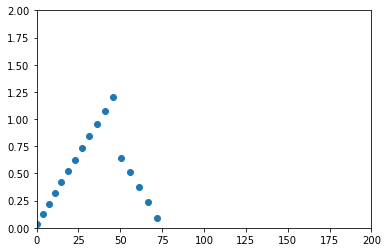

In [221]:
#depthTaperFn = cosine_taper(depthFn, ndp.crustViscCutoffDepth, ndp.crustViscEndWidth)

#ctanhFn0 = 0.5*(1. - fn.math.cos((np.pi*(depthFn - ndp.crustViscCutoffDepth))/(ndp.crustViscEndWidth)) ) 


#ctanhFn1 = fn.branching.conditional( ((depthFn < ndp.crustViscCutoffDepth, 0. ),
#                                            (depthFn > ndp.crustViscCutoffDepth + ndp.crustViscEndWidth, 1. ), 
#                                           (True,                      ctanhFn0)  ))

#lWalls = mesh.specialSets["MinI_VertexSet"]

#%pylab inline
#fig = plt.Figure()
#ax1  = plt.subplot(1,1,1)

#ax1.plot(interfaceDiffusion.evaluate(iWalls)[:,0], sf.lengthScale*(1. - mesh.data[iWalls.data][:,1])/1e3, )
#ax1.plot(diffusion.evaluate(iWalls)[:,0], sf.lengthScale*(1. - mesh.data[iWalls.data][:,1])/1e3, )
#ax1.plot(FaultVisc, sf.lengthScale/1e3*(1. - markerEvalPoints[:,1]) )

#lWalls = mesh.specialSets["MinI_VertexSet"]

#crustyielding0.evaluate(lWalls)



#plt.vlines(ndp.crustViscCutoffDepth*sf.lengthScale/1e3, 0, 1)
#plt.vlines(ndp.crustViscCutoffDepth*sf.lengthScale/1e3 - 50, 0, 1e5)
#plt.vlines(ndp.crustViscCutoffDepth*sf.lengthScale/1e3 + 50, 0, 1e5)

#ax1.set_xscale('log')
#ax1.set_ylim(250., 0.)

#ax1.plot( ((1 - coordinate.evaluate(lWalls))[:,1])*sf.lengthScale/1e3, ctanhFn.evaluate(lWalls)[:,0])
#ax1.plot( ((1 - coordinate.evaluate(lWalls))[:,1])*sf.lengthScale/1e3, ctanhFn0.evaluate(lWalls)[:,0])
#ax1.plot( ((1 - coordinate.evaluate(lWalls))[:,1])*sf.lengthScale/1e3, depthTaperFn.evaluate(lWalls)[:,0])
#ax1.plot( ((1 - coordinate.evaluate(lWalls))[:,1])*sf.lengthScale/1e3, depthTaperFn.evaluate(lWalls)[:,0])


#ax1.scatter( ((1 - coordinate.evaluate(lWalls))[:,1])*sf.lengthScale/1e3, crustyielding0.evaluate(lWalls)[:,0])

#ax1.set_xlim(0., 200.)
#ax1.set_ylim(0., 2.)

In [73]:
#fig3= glucifer.Figure(quality=3, boundingBox=bBox)
#fig3.append( glucifer.objects.Surface(mesh,viscmaxCrustFn, pointSize=2))
#fig3.show()
#fig3.save_database('test.gldb')

lWalls = mesh.specialSets["MinI_VertexSet"]
testG = temperatureFn + adiabaticCorrectFn + ndp.surfaceTemp

%pylab inline
#vals = diffusion.evaluate(mesh.data[iWalls.data])[:,0]
vals = testG.evaluate(mesh.data[lWalls.data])[:,0]

fig, ax = plt.subplots()

#ax.plot(vals[0:-1] - vals[1:])
ax.plot(mesh.data[lWalls.data][:,1], vals)
#ax.plot(mesh.data[lWalls.data][:,1], depthFn.evaluate(mesh.data[lWalls.data]))


ax.set_xlim(0.65, 1)

diffusionLM = ndp.lowerMantleViscFac*(1./ndp.lowerMantlePreExp)*\
            fn.math.exp( ((ndp.lowerMantleEnergy + (depthFn*ndp.lowerMantleVolume))/((temperatureFn+ adiabaticCorrectFn + ndp.surfaceTemp))))

%pylab inline

fig, ax = plt.subplots()
ax.scatter(diffusion.evaluate(mesh.data[iWalls.data])[:,0], mesh.data[iWalls.data][:,1] )
ax.scatter(diffusionLM.evaluate(mesh.data[iWalls.data])[:,0], mesh.data[iWalls.data][:,1] )

ax.set_xlim(0.01, 1000)
ax.set_ylim(0.65, 1)
ax.set_xscale('log')

## Buoyancy 

In [197]:
#md.compBuoyancy = True

#Thermal Buoyancy

z_hat = ( 0.0, 1.0 )


if md.thermal:
    thermalBuoyancyFn = ndp.rayleigh*temperatureField
else:
    thermalBuoyancyFn = ndp.rayleigh*proxyTempVariable

In [ ]:
#Thermal Buoyancy

z_hat = ( 0.0, -1.0 )


if md.thermal:
    thermalBuoyancyFn = ndp.rayleigh*(1. - temperatureField)
else:
    thermalBuoyancyFn = ndp.rayleigh*(1. - proxyTempVariable)

In [ ]:
#Set up compositional buoyancy contributions


buoyancy_factor = (dp.refGravity*sf.lengthScale**3)/(sf.viscosityScale*dp.refDiffusivity)

air_comp_buoyancy  = (dp.refDensity - 1000.)*buoyancy_factor          #roughly sea-water density
basalt_comp_buoyancy  = (dp.refDensity - 2940.)*buoyancy_factor       #
#harz_comp_buoyancy = (dp.refDensity - 3235.)*buoyancy_factor
pyrolite_comp_buoyancy = (dp.refDensity - 3300.)*buoyancy_factor


#if we're using a thicker crust for numerical resolution, make a bouyancy adjustment
averageCrustThickness = 6e3
basalt_comp_buoyancy *=(averageCrustThickness/dp.mantleCrustDepth)

In [ ]:
if not md.compBuoyancy:
    pyrolitebuoyancyFn =  (thermalBuoyancyFn)*z_hat
#    harzbuoyancyFn =      (ndp.RA*temperatureField) 
    basaltbuoyancyFn =    (thermalBuoyancyFn)*z_hat
    
    airbuoyancyFn =    (fn.misc.constant(air_comp_buoyancy))*z_hat

else : 
    pyrolitebuoyancyFn =  (thermalBuoyancyFn - pyrolite_comp_buoyancy)*z_hat
#    harzbuoyancyFn =      (ndp.RA*temperatureField*taFn) -\
#                           harz_comp_buoyancy
    basaltbuoyancyFn =    (thermalBuoyancyFn - basalt_comp_buoyancy)*z_hat
    
    airbuoyancyFn =    (fn.misc.constant(air_comp_buoyancy))*z_hat
                           
                           
                           
buoyancyMapFn = fn.branching.map( fn_key = materialVariable,
                         mapping = {airID:airbuoyancyFn ,
                                    crustID:basaltbuoyancyFn, 
                                    mantleID:pyrolitebuoyancyFn} )
#                                    harzIndex:harzbuoyancyFn} )

In [ ]:
fig= glucifer.Figure(quality=3, boundingBox= bBox)

fig.append( glucifer.objects.Points(swarm, buoyancyMapFn[1], pointSize=2))
#fig.show()


## Any other functions we'll need

In [ ]:
###################
#Create integral, max/min templates 
###################


globRestFn = 1.

def volumeint(Fn = 1., rFn=globRestFn):
    return uw.utils.Integral( Fn*rFn,  mesh )

def surfint(Fn = 1., rFn=globRestFn, surfaceIndexSet=mesh.specialSets["MaxJ_VertexSet"]):
    return uw.utils.Integral( Fn*rFn, mesh=mesh, integrationType='Surface', surfaceIndexSet=surfaceIndexSet)

def maxMin(Fn = 1.):
    #maxMin(Fn = 1., rFn=globRestFn
    #vuFn = fn.view.min_max(Fn*rFn) #the restriction functions don't work with the view.min_max fn yet
    vuFn = fn.view.min_max(Fn)
    return vuFn

In [ ]:
#marker.compute_signed_distance

## Stokes system and solver

In [ ]:
print('got to Stokes')

In [ ]:
#velocityField.data[:] = 0.
#pressureField.data[:] = 0.

In [ ]:
stokesPIC = uw.systems.Stokes( velocityField  = velocityField, 
                                   pressureField  = pressureField,
                                   conditions     = [freeslipBC,],
                                   fn_viscosity   = viscosityMapFn, 
                                   fn_bodyforce   = buoyancyMapFn )



In [ ]:
solver = uw.systems.Solver(stokesPIC)


if md.penaltyMethod:
    solver.set_inner_method("mumps")
    solver.options.scr.ksp_type="cg"
    solver.set_penalty(1.0e7)
    solver.options.scr.ksp_rtol = 1.0e-4

else:
    solver.options.main.Q22_pc_type='gkgdiag'
    solver.options.scr.ksp_rtol=5e-5
    solver.set_inner_method('mg')
    solver.options.mg.levels = 4
    
    
    
#avoid this solve if restarting
if not cp.restart:
    solver.solve(nonLinearIterate=True, nonLinearTolerance=md.nltol)
    solver.print_stats()

In [ ]:
#remove drift in pressure
_pressure = surfint(pressureField)
_surfLength = surfint()
surfLength = _surfLength.evaluate()[0]

pressureSurf = _pressure.evaluate()[0]   
pressureField.data[:] -= pressureSurf/surfLength

In [ ]:
#This is the dynamic pressure converted to a proxy dimensionless depth, so it can be composed with the Byerlee's law
#dynamicPressureProxyDepthFn = pressureField/ndp.rayleigh
#cp.restart


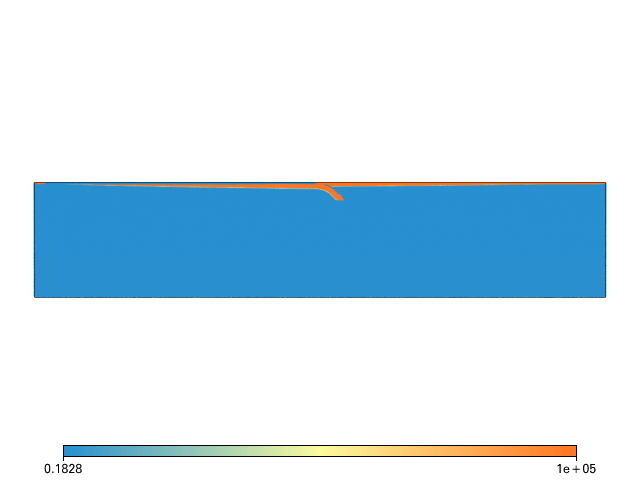

In [198]:
#fig= glucifer.Figure(quality=3)

#fig.append( glucifer.objects.Mesh(mesh, opacity=0.2))
#fig.append( glucifer.objects.Points(swarm, dynamicPressureProxyDepthFn + depthFn, pointSize=2))
#fig.append( glucifer.objects.Points(swarm, viscosityMapFn, pointSize=2))

#fig.append( glucifer.objects.Points(marker.swarm,  pointSize=2))

#fig.append( glucifer.objects.VectorArrows(mesh, velocityField, arrowHead=1, scaling=0.00005))
#fig.append( glucifer.objects.Surface(mesh,difftanhFn ))
#fig.show()
#fig.save_database('test.gldb')

In [ ]:
#%pylab inline
#plt.scatter(mesh.data[tWalls.data][:,0], pressureField.evaluate(mesh.data[tWalls.data] - (0., 20e3/sf.lengthScale)), s=0.5) 
#plt.scatter(mesh.data[tWalls.data][:,0], pressureField.evaluate(tWalls), s=0.5) 


## Setup advection-diffusion, swarm advection

In [ ]:
advector = uw.systems.SwarmAdvector( swarm=swarm, velocityField=velocityField, order=2 )




if md.thermal:
    advDiff = uw.systems.AdvectionDiffusion( phiField       = temperatureField, 
                                         phiDotField    = temperatureDotField, 
                                         velocityField  = velocityField,
                                         fn_sourceTerm    = 0.0,
                                         fn_diffusivity = 1., 
                                         #conditions     = [neumannTempBC, dirichTempBC] )
                                         conditions     = [ dirichTempBC] )


## Initial thermal diffusion

Working, but not tuned or tested

In [ ]:
if md.diffuseInitial and md.thermal:

    velocityField0   = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=2 )
    velocityField0.data[:] = 0.0

    testDepth = 50e3/sf.lengthScale
    testWidth = 10e3/sf.lengthScale 

    difftanhFn = 0.5*(fn.math.tanh((depthFn - testDepth)/(testWidth))) + 0.5


    advDiff0 = uw.systems.AdvectionDiffusion( phiField       = temperatureField, 
                                             phiDotField    = temperatureDotField, 
                                             velocityField  = velocityField0,
                                             fn_sourceTerm    = 0.0,
                                             fn_diffusivity = difftanhFn, 
                                             #conditions     = [neumannTempBC, dirichTempBC] )
                                             conditions     = [ dirichTempBC] )




    diff_for  = md.diffuseInitial*(3600.*365.*24.)/sf.time
    dt_diff = 0.
    step_diff = 0.
    while dt_diff < diff_for:
        dt_now = advDiff0.get_max_dt()
        advDiff0.integrate(dt_now)
        dt_diff += dt_now
        step_diff += 1
        print('years and step: {} {}'.format((dt_diff*sf.time)/(3600.*365.*24.), step_diff))   

    

    #delete stuff if not needed

    del difftanhFn
    del advDiff0
    del velocityField0


    proxyTempVariable.data[:] = temperatureField.evaluate(swarm)

In [ ]:
print('past first solve')

## Viz

In [ ]:
#Build a depth dependent mask for the vizualisation

depthVariable      = swarm.add_variable( dataType="float", count=1 )
depthVariable.data[:] = depthFn.evaluate(swarm)

vizVariable      = swarm.add_variable( dataType="int", count=1 )
vizVariable.data[:] = 0

for index, value in enumerate(depthVariable.data[:]):
    #print index, value
    if np.random.rand(1)**30 > value/(mesh.maxCoord[1] - mesh.minCoord[1]):
        vizVariable.data[index] = 1
    #if value > 660e3/sf.lengthScale:
    #    vizVariable.data[index] = 0
        
        
del index, value    #get rid of any variables that might be pointing at the .data handles (these are!)

#Now randomly cull more particles if desired

removeRandom = True
if removeRandom:
    reducFac = 0.6  #0.9 > remove 90%
    nonzs = np.where(vizVariable.data[:,0] == 1)[0].copy()
    nstart =  nonzs.shape[0]
    nend = int(np.ceil(nstart*reducFac))
    np.random.shuffle(nonzs)
    nstart, nend

    vizVariable.data[nonzs[:nend]] = 0
    del nonzs, nstart, nend



#Build any Functios we need for Viz

stressII = 2.*strainRate_2ndInvariant*viscosityMapFn
stressXX = 2.*symStrainrate[0]*viscosityMapFn




In [ ]:
#Set up the gLucifer stores

fullpath = os.path.join(outputPath + "gldbs/")
store1 = glucifer.Store(fullpath + 'subduction1.gldb')
store2 = glucifer.Store(fullpath + 'subduction2.gldb')
store3 = glucifer.Store(fullpath + 'subduction3.gldb')
store4 = glucifer.Store(fullpath + 'subduction4.gldb')
store5 = glucifer.Store(fullpath + 'subduction5.gldb')
store6 = glucifer.Store(fullpath + 'subduction6.gldb')


fig1 = glucifer.Figure(store1,figsize=(300*np.round(md.aspectRatio,2),300))
if md.thermal:
    fig1.append( glucifer.objects.Points(swarm, temperatureField, pointSize=2,  valueRange=[0.0, 1.0], fn_mask=vizVariable))
else:
    fig1.append( glucifer.objects.Points(swarm, proxyTempVariable, pointSize=2, valueRange=[0.0, 1.0],  fn_mask=vizVariable))

 


fig2 = glucifer.Figure(store2,figsize=(300*np.round(md.aspectRatio,2),300))
fig2.append( glucifer.objects.Points(swarm, viscosityMapFn, pointSize=2, fn_mask=vizVariable, logScale=True, valueRange=[100.*ndp.viscosityMin, ndp.viscosityMax]))
fig2.append( glucifer.objects.VectorArrows(mesh, velocityField, arrowHead=1, scaling=0.00005))


fig3 = glucifer.Figure(store3,figsize=(300*np.round(md.aspectRatio,2),300))
fig3.append( glucifer.objects.Points(swarm, pressureField, pointSize=2, fn_mask=vizVariable))
fig3.append( glucifer.objects.Mesh(mesh))

fig3.append( glucifer.objects.Points(marker.swarm, pointSize=5, colourBar=False))


fig4 = glucifer.Figure(store4,figsize=(300*np.round(md.aspectRatio,2),300))
fig4.append( glucifer.objects.Points(swarm, strainRate_2ndInvariant , pointSize=2, fn_mask=vizVariable))
fig4.append( glucifer.objects.Points(marker.swarm, pointSize=5, colourBar=False))

fig5 = glucifer.Figure(store5,figsize=(300*np.round(md.aspectRatio,2),300))
fig5.append( glucifer.objects.Points(swarm, stressII , pointSize=2, fn_mask=vizVariable, valueRange=[0.0,ndp.yieldStressMax]))
fig5.append( glucifer.objects.Points(swarm, stressXX , pointSize=2, fn_mask=vizVariable, valueRange=[-1*ndp.yieldStressMax/2.,ndp.yieldStressMax/2.]))
fig5.append(glucifer.objects.Contours(mesh, temperatureField))

fig6 = glucifer.Figure(store6,figsize=(300*np.round(md.aspectRatio,2),300))
fig6.append( glucifer.objects.Points(swarm, materialVariable, pointSize=2, fn_mask=vizVariable))
fig6.append( glucifer.objects.Mesh(mesh))


## Integrals and metrics

In [ ]:
_pressure = surfint(pressureField)
_surfLength = surfint()
surfLength = _surfLength.evaluate()[0]
pressureSurf = _pressure.evaluate()[0]   
pressureField.data[:] -= pressureSurf/surfLength

## Update functions for main loop

In [ ]:
def main_update():
    
    
    if md.thermal:
        dt = advDiff.get_max_dt()*md.courantFac #additional md.courantFac helps stabilise advDiff
        advDiff.integrate(dt)
        
    else:
        dt = advector.get_max_dt()
        
    advector.integrate(dt)
    marker.advection(dt)
    
    #remove drift in pressure
    pressureSurf = _pressure.evaluate()[0]   
    pressureField.data[:] -= pressureSurf/surfLength
    
    
    return time+dt, step+1
    

In [ ]:
def main_update2(next_image_step):
    
    """
    This includes some functionality for image / file writing at speciified time intervals,
    Assumes global variables:
        time, step, files_freq, next_image_step
    
    if numerical dt exceeds next specified writing point
    override dt make sure we hit that point
    Set some flags so that image / file writing proceeds
    
    """
    
    
    if md.thermal:
        dt = advDiff.get_max_dt()*md.courantFac #additional md.courantFac helps stabilise advDiff
        advDiff.integrate(dt)
        
    else:
        dt = advector.get_max_dt()
        
    #This relates to file writing at set period:
    #override dt make sure we hit certain time values
    #Set some flags so that image / file writing proceeds
    
    if step == 0:
        files_this_step = True
    else:
        files_this_step = False
    
    if time + dt >= next_image_step:
        dt = next_image_step - time
        files_this_step = True
        next_image_step += files_freq #increment time for our next image / file dump
        
        
    #Do advection    
        
    advector.integrate(dt)
    marker.advection(dt)
    
    #remove drift in pressure
    pressureSurf = _pressure.evaluate()[0]   
    pressureField.data[:] -= pressureSurf/surfLength
    
    
    return time+dt, step+1, files_this_step, next_image_step
    

In [ ]:
def viz_update():
    
    #Rebuild the viz. mask
    vizVariable.data[:] = 0

    for index, value in enumerate(depthVariable.data[:]):
        #print index, value
        if np.random.rand(1)**5 > value/(mesh.maxCoord[1] - mesh.minCoord[1]):
            vizVariable.data[index] = 1

    del index, value    #get rid of any variables that might be pointing at the .data handles (these 
    
    if removeRandom:
        reducFac = 0.6  #0.9 > remove 90%
        nonzs = np.where(vizVariable.data[:,0] == 1)[0].copy()
        nstart =  nonzs.shape[0]
        nend = int(np.ceil(nstart*reducFac))
        np.random.shuffle(nonzs)
        nstart, nend

        vizVariable.data[nonzs[:nend]] = 0
        del nonzs, nstart, nend   
    
    #save gldbs
    fullpath = os.path.join(outputPath + "gldbs/")
    
    store1.step = step
    fig1.save( fullpath + "Temp" + str(step).zfill(5))
    
    store2.step = step
    fig2.save( fullpath + "visc" + str(step).zfill(5))
    
    store3.step = step
    fig3.save( fullpath + "pressure" + str(step).zfill(5))
    
    store4.step = step
    fig4.save( fullpath + "strainrate" + str(step).zfill(5))
    
    store5.step = step
    fig5.save( fullpath + "strainrate" + str(step).zfill(5))
    
    store6.step = step
    fig6.save( fullpath + "strainrate" + str(step).zfill(5))
    

In [ ]:
def swarm_update():
    
    #run swarm repopulation
    repopulate()
    
    
    #rebuild the ridge mask guy
    nearSurfTempGrad = fn.branching.conditional( ((depthFn < depthMorTest, temperatureField.fn_gradient[1] ), 
                                           (True,                      0.)  ))

    morRestrictFn = fn.math.abs(nearSurfTempGrad) < 50.
    
    
    #rebuild the material graph condition list, and apply to swarm
    MG.build_condition_list(materialVariable)
    materialVariable.data[:] = fn.branching.conditional(MG.condition_list).evaluate(swarm)
    
    
    

In [ ]:
def markerLine_update():
    cutoffDepth = 250e3/sf.lengthScale
    mask = marker.swarm.particleCoordinates.data[:,1] < (mesh.maxCoord[1] - cutoffDepth)

    with marker.swarm.deform_swarm():
        marker.swarm.particleCoordinates.data[mask] = (999999.,999999.)
        
    #Any line healing stuff to go here

def files_update():
    
    #We don't evaluate on the marker but, here (2/3 of the way towards teh top of the fault region)
    ds = ndp.faultThickness/2.5
    
    #Need to write a safeguard that checks that 
    markerEval = marker.swarm.particleCoordinates.data - marker.director.data[...]*ds
    
    midlithEval = surfaceLine.swarm.particleCoordinates.data  - [0.0, 30e3/sf.lengthScale]
    
    
    #define any NN interps we'll need

    ix1, weights1, d1 = nn_evaluation(swarm.particleCoordinates.data, markerEval, n=2, weighted=True)
    ix2, weights2, d2 = nn_evaluation(swarm.particleCoordinates.data, surfaceLine.swarm.particleCoordinates.data, n=5, weighted=True)
    ix3, weights3, d3 = nn_evaluation(swarm.particleCoordinates.data, midlithEval, n=5, weighted=True)
  


    #because we're using points and not a swarm, needs to be safeguarded
    #marker stuff  
    if markerEval.shape[0]:
        markerEvalPoints.data[:] = markerEval

        #Update the data:
        if len(weights1): #i.e. if there is anu markerLine in this proc
            markerVisc.data[:,0] =  np.average(viscosityMapFn.evaluate(swarm)[:,0][ix1], weights=weights1, axis=len((weights1.shape)) - 1)
        markerSr2Inv.data[:] = strainRate_2ndInvariant.evaluate(markerEval)
        markerSrxx.data[:] = symStrainrate[0].evaluate(markerEval)
        markerSryy.data[:] = symStrainrate[1].evaluate(markerEval)
        markerYieldStress.data[:] = crustysf.evaluate(markerEval)
        markerPressure.data[:] = pressureField.evaluate(markerEval) #only relavent for thermal models
        markerTemp.data[:] = temperatureField.evaluate(markerEval) #only relavent for thermal models
    
    #Surface stuff 
    
    surfVelx.data[:] = velocityField[0].evaluate(surfaceLine.swarm)
    surfStrain.data[:] = symStrainrate[1].evaluate(surfaceLine.swarm)#* \
    surfTgrad.data[:] = temperatureField.fn_gradient[1].evaluate(surfaceLine.swarm)

    if len(weights2):
        surfVisc.data[:,0] =    np.average(viscosityMapFn.evaluate(swarm)[:,0][ix2], weights=weights2, axis=len((weights2.shape)) - 1)
        surfTgrad.data[:] = temperatureField.fn_gradient[1].evaluate(surfaceLine.swarm)

    
    #Mid lith stuff
    
    if midlithEval.shape[0]:
        midlithEvalEvalPoints.data[:] = midlithEval
        if len(weights3): #i.e. if there is anu markerLine in this proc
                midlithVisc.data[:,0] =  np.average(viscosityMapFn.evaluate(swarm)[:,0][ix3], weights=weights3, axis=len((weights3.shape)) - 1)
        midlithSr2Inv.data[:] = strainRate_2ndInvariant.evaluate(midlithEval)
        midlithStrainTens.data[:] = symStrainrate.evaluate(midlithEval)
    
    #Save the files:
    fullpath = os.path.join(outputPath + "files/")
    
    #marker
    markerEvalPoints.save( fullpath + "markerEval" + str(step).zfill(5))
    markerYieldStress.save( fullpath + "markerYieldStress" + str(step).zfill(5))
    markerTemp.save( fullpath + "markerTemp" + str(step).zfill(5))
    markerVisc.save( fullpath + "markerVisc" + str(step).zfill(5))
    markerSr2Inv.save( fullpath + "markerSr2Inv" + str(step).zfill(5))
    markerSrxx.save( fullpath + "markerSrxx" + str(step).zfill(5))
    markerSryy.save( fullpath + "markerSryy" + str(step).zfill(5))
    markerPressure.save( fullpath + "markerPressure" + str(step).zfill(5))
    
    #suface
    surfVelx.save( fullpath + "surfVelx" + str(step).zfill(5))
    surfStrain.save( fullpath + "surfStrain" + str(step).zfill(5))
    surfVisc.save( fullpath + "surfVisc" + str(step).zfill(5))
    surfTgrad.save( fullpath + "surfTgrad" + str(step).zfill(5))

    
    #mid lith
    midlithEvalEvalPoints.save( fullpath + "midlithEvalEvalPoints" + str(step).zfill(5))
    midlithVisc.save( fullpath + "midlithVisc" + str(step).zfill(5))
    midlithSr2Inv.save( fullpath + "midlithSr2Inv" + str(step).zfill(5))
    midlithStrainTens.save( fullpath + "midlithStrainTens" + str(step).zfill(5))




    
    
    
    


In [ ]:
def files_update():
    
    #get all coords for the marker
    marker.swarm.shadow_particles_fetch()
    dims = marker.swarm.particleCoordinates.data.shape[1]
    pc = np.append(marker.swarm.particleCoordinates.data,
                       marker.swarm.particleCoordinates.data_shadow)
    all_coords = pc.reshape(-1,dims)
    pd = np.append(marker.director.data,
                       marker.director.data_shadow)
    all_directs = pd.reshape(-1,dims)
    
    #We don't evaluate on the fault but at a small distance in the norma direction
    ds = ndp.faultThickness/2.
    markerEvalPoints = all_coords - all_directs[...]*ds
    
    
    #Create the temp Swarm
    markerEval = uw.swarm.Swarm( mesh=mesh )
    markerEval.add_particles_with_coordinates(markerEvalPoints)
    
    #Create the temp Swarm vars.
    
    markerVisc = uw.swarm.SwarmVariable(markerEval, 'double', 1)
    markerSr2Inv = uw.swarm.SwarmVariable(markerEval, 'double', 1)
    markerSrxx = uw.swarm.SwarmVariable(markerEval, 'double', 1)
    markerSryy = uw.swarm.SwarmVariable(markerEval, 'double', 1)
    markerEvalPoints = uw.swarm.SwarmVariable(markerEval, 'double', 2)
    markerYieldStress = uw.swarm.SwarmVariable(markerEval, 'double', 1)
    markerTemp = uw.swarm.SwarmVariable(markerEval, 'double', 1)
    markerPressure = uw.swarm.SwarmVariable(markerEval, 'double', 1)

    
    midlithEval = surfaceLine.swarm.particleCoordinates.data  - [0.0, 30e3/sf.lengthScale]
    
    
    #define any NN interps we'll need

    ix1, weights1, d1 = nn_evaluation(swarm.particleCoordinates.data, markerEval.particleCoordinates.data, n=5, weighted=True)
    ix2, weights2, d2 = nn_evaluation(swarm.particleCoordinates.data, surfaceLine.swarm.particleCoordinates.data, n=5, weighted=True)
    ix3, weights3, d3 = nn_evaluation(swarm.particleCoordinates.data, midlithEval, n=5, weighted=True)
  


    #safeguarding - prob not necessary, partial relic of earlier implementation 
    #Fault stuff  
    if markerEval.particleCoordinates.data.shape[0]:
        markerEvalPoints.data[:] = markerEval.particleCoordinates.data

        #Update the data:
        if len(weights1): #i.e. if there is anu markerLine in this proc
            markerVisc.data[:,0] =  np.average(viscosityMapFn.evaluate(swarm)[:,0][ix1], weights=weights1, axis=len((weights1.shape)) - 1)
        markerSr2Inv.data[:] = strainRate_2ndInvariant.evaluate(markerEval)
        markerSrxx.data[:] = symStrainrate[0].evaluate(markerEval)
        markerSryy.data[:] = symStrainrate[1].evaluate(markerEval)
        markerYieldStress.data[:] = crustysf.evaluate(markerEval)
        markerPressure.data[:] = pressureField.evaluate(markerEval) #only relavent for thermal models
        markerTemp.data[:] = temperatureField.evaluate(markerEval) #only relavent for thermal models
    
    #Surface stuff 
    
    surfVelx.data[:] = velocityField[0].evaluate(surfaceLine.swarm)
    surfStrain.data[:] = symStrainrate[1].evaluate(surfaceLine.swarm)#* \
    surfTgrad.data[:] = temperatureField.fn_gradient[1].evaluate(surfaceLine.swarm)

    if len(weights2):
        surfVisc.data[:,0] =    np.average(viscosityMapFn.evaluate(swarm)[:,0][ix2], weights=weights2, axis=len((weights2.shape)) - 1)
        surfTgrad.data[:] = temperatureField.fn_gradient[1].evaluate(surfaceLine.swarm)

    
    #Mid lith stuff
    
    if midlithEval.shape[0]:
        midlithEvalEvalPoints.data[:] = midlithEval
        if len(weights3): #i.e. if there is anu markerLine in this proc
                midlithVisc.data[:,0] =  np.average(viscosityMapFn.evaluate(swarm)[:,0][ix3], weights=weights3, axis=len((weights3.shape)) - 1)
        midlithSr2Inv.data[:] = strainRate_2ndInvariant.evaluate(midlithEval)
        midlithStrainTens.data[:] = symStrainrate.evaluate(midlithEval)
    
    #Save the files:
    fullpath = os.path.join(outputPath + "files/")
    
    #marker
    markerEvalPoints.save( fullpath + "markerEval" + str(step).zfill(5))
    markerYieldStress.save( fullpath + "markerYieldStress" + str(step).zfill(5))
    markerTemp.save( fullpath + "markerTemp" + str(step).zfill(5))
    markerVisc.save( fullpath + "markerVisc" + str(step).zfill(5))
    markerSr2Inv.save( fullpath + "markerSr2Inv" + str(step).zfill(5))
    markerSrxx.save( fullpath + "markerSrxx" + str(step).zfill(5))
    markerSryy.save( fullpath + "markerSryy" + str(step).zfill(5))
    markerPressure.save( fullpath + "markerPressure" + str(step).zfill(5))
    
    #suface
    surfVelx.save( fullpath + "surfVelx" + str(step).zfill(5))
    surfStrain.save( fullpath + "surfStrain" + str(step).zfill(5))
    surfVisc.save( fullpath + "surfVisc" + str(step).zfill(5))
    surfTgrad.save( fullpath + "surfTgrad" + str(step).zfill(5))

    
    #mid lith
    midlithEvalEvalPoints.save( fullpath + "midlithEvalEvalPoints" + str(step).zfill(5))
    midlithVisc.save( fullpath + "midlithVisc" + str(step).zfill(5))
    midlithSr2Inv.save( fullpath + "midlithSr2Inv" + str(step).zfill(5))
    midlithStrainTens.save( fullpath + "midlithStrainTens" + str(step).zfill(5))



    
    uw.barrier()
    #big delete - all components of the temporary swarm 
    
    del pc
    del all_coords
    del pd
    del all_directs
    del markerEvalPoints
    del markerVisc
    del markerSr2Inv
    del markerSrxx 
    del markerSryy
    del markerYieldStress
    del markerEval

In [ ]:
#del markerSr2Inv
#markerSr2Inv

In [ ]:
#step = 2
#
#files_update()

In [ ]:
def xdmfs_update():
    
    #define any NN interps we'll need
    ix1, weights1, d1 = nn_evaluation(swarm.particleCoordinates.data, mesh.data, n=5, weighted=True)
    
    
    #rebuild any mesh vars that are not self-updating
    viscosityField.data[:,0] =  np.average(viscosityMapFn.evaluate(swarm)[:,0][ix1], weights=weights1, axis=len((weights1.shape)) - 1)
    strainRateField.data[:] = strainRate_2ndInvariant.evaluate(mesh)
     
    
    fullpath = os.path.join(outputPath + "xdmf/")
    #if not os.path.exists(fullpath+"mesh.h5"):
    #    _mH = mesh.save(fullpath+"mesh.h5")
    
    try:
        _mH
    except:
        _mH = mesh.save(fullpath+"mesh.h5")
    
    
    #Part 1
    mh = _mH
    vH = velocityField.save(fullpath + "velocity_" + str(step) +".h5")
    tH = temperatureField.save(fullpath + "temp_" + str(step) + ".h5")
    srH = strainRateField.save(fullpath + "strainrate_" + str(step) +".h5")
    viscH = viscosityField.save(fullpath + "visc_" + str(step) + ".h5")
    
    #part2
    
    velocityField.xdmf(fullpath + "velocity_" + str(step), vH, 'velocity', mh, 'mesh', modeltime=time)
    temperatureField.xdmf(fullpath + "temp_" + str(step), tH, 'temperature', mh, 'mesh', modeltime=time)
    strainRateField.xdmf(fullpath + "strainrate_" + str(step), srH, 'strainrate', mh, 'mesh', modeltime=time)
    viscosityField.xdmf(fullpath + "visc_" + str(step), viscH, 'visc', mh, 'mesh', modeltime=time)

In [ ]:
def update_wedge_pos():
    pass
    

In [ ]:
wedgeFn = update_wedge_pos()

## Main loop

In [ ]:
time = cp.time()  # Initial time
step = cp.step()   # Initial timestep
steps_output = 5   # output every 10 timesteps
metrics_output = 5
files_output = 10

files_freq  = md.filesMy*(3600.*365.*24.)/sf.time  #applies to files and gldbs
files_this_step = False
next_image_step = (np.floor(time/files_freq)+ 1.) *files_freq 


In [ ]:
#checkpoint at time zero
if not cp.restart:
    cp.saveObjs(step, time)
    cp.saveDicts(step, time)

In [ ]:
while step < md.maxSteps:
    
    solver.solve(nonLinearIterate=True, nonLinearTolerance=md.nltol)
    
    # main
    time,step,files_this_step, next_image_step = main_update2(next_image_step)
    
    #markers / markerLines
    if step % md.swarmUpdate == 0:
        markerLine_update()    
    
    #checkpoint
    if step % md.checkpointEvery == 0:
        cp.saveObjs(step, time)
        cp.saveDicts(step, time)
        
    #particles
    if step % md.swarmUpdate == 0:
        swarm_update()
        
        
    #Viz
    if files_this_step:
        viz_update()    

        
    #files
    if files_this_step:
        files_update()
        
        
    #xdmfs
    if files_this_step:
        xdmfs_update()
    
        
    print 'step =',step
    

    

print 'step =',step

In [ ]:
#ix1, weights1, d1 = nn_evaluation(swarm.particleCoordinates.data, mesh.data[tWalls.data], n=5, weighted=True)
#surfStressData =    np.average(stressFn[1].evaluate(swarm)[:,0][ix1], weights=weights1, axis=len((weights1.shape)) - 1)

In [ ]:
#vx = velocityField[0].evaluate(mesh.data[tWalls.data])
#press = pressureField.evaluate(mesh.data[tWalls.data])

In [ ]:
#%pylab inline

# new style method 1; unpack the axes
#fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=False)
#ax1.plot((-1.*surfStressData*sf.stress), c='r')
#ax1.plot((press*sf.stress))
#ax2.plot(vx)


In [ ]:
#We don't evaluate on the marker but, here
#ds = ndp.faultThickness/2.
#markerEval = marker.swarm.particleCoordinates.data - marker.director.data[...]*ds

#marker2 = markerLine2D(mesh, velocityField,markerEval[:,0], markerEval[:,1], ndp.faultThickness,  6)

#with marker2.swarm.deform_swarm():
#    marker2.swarm.particleCoordinates.data[:] += marker2.director.data*ndp.faultThickness

In [ ]:
#fig1 = glucifer.Figure(figsize=(300*np.round(md.aspectRatio,2),300))

#fig2.append( glucifer.objects.Points(swarm, materialVariable, pointSize=2, fn_mask=vizVariable))
#fig1.append( glucifer.objects.Points(swarm, materialVariable,pointSize=2, fn_mask=vizVariable))
#fig1.append( glucifer.objects.Points(marker.swarm, colours='red'))
#fig1.append( glucifer.objects.Points(marker2.swarm))

#fig2.append( glucifer.objects.Points(testMarker.swarm))


#fig1.append( glucifer.objects.VectorArrows(mesh, velocityField, arrowHead=5, scaling=0.00005))
#fig1.save_database('test.gldb')

In [ ]:
#import pickle
##with open('dp.pkl', 'rb') as fp:
#    dill = pickle.load(fp)
#dill